In [14]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Functions definition

In [5]:
# Convert latitude and longitude coordinates to plane coordinates
def LatLon2XY(latitude, longitude):
    a = 6378137.0
    e2 = 0.0066943799013

    # Convert latitude and longitude to radians
    latitude2Rad = (math.pi / 180.0) * latitude

    beltNo = int((longitude + 1.5) / 3.0)
    L = beltNo * 3   # Calculate the central meridian
    l0 = longitude - L 
    tsin = math.sin(latitude2Rad)
    tcos = math.cos(latitude2Rad)
    t = math.tan(latitude2Rad)
    m = (math.pi / 180.0) * l0 * tcos
    et2 = e2 * pow(tcos, 2)
    et3 = e2 * pow(tsin, 2)
    X = 111132.9558 * latitude - 16038.6496 * math.sin(2 * latitude2Rad) + 16.8607 * math.sin(
        4 * latitude2Rad) - 0.0220 * math.sin(6 * latitude2Rad)
    N = a / math.sqrt(1 - et3)

    x = X + N * t * (0.5 * pow(m, 2) + (5.0 - pow(t, 2) + 9.0 * et2 + 4 * pow(et2, 2)) * pow(m, 4) / 24.0 + (
    61.0 - 58.0 * pow(t, 2) + pow(t, 4)) * pow(m, 6) / 720.0)
    y = 500000 + N * (m + (1.0 - pow(t, 2) + et2) * pow(m, 3) / 6.0 + (
    5.0 - 18.0 * pow(t, 2) + pow(t, 4) + 14.0 * et2 - 58.0 * et2 * pow(t, 2)) * pow(m, 5) / 120.0)

    return x, y

In [7]:
def get_data(x):
    x = x[1:]
    return x

# map the original dataset to a planar coordinates system
def dataprocess(filename, month):
    df = pd.read_csv(filename)  # read dataset
    df = df.drop(['order_time'],axis=1)
    df = df.drop(['dispatch_time'],axis=1)
    df = df.drop(['cancel_time'],axis=1)
    df = df.dropna()
    
    # coordinates conversion
    df['origin_XY']= df.apply(lambda row : LatLon2XY(row['origin_lat'], row['origin_lon']), axis = 1)
    df['origin_X'] = df['origin_XY'].map(lambda x :x[0])
    df['origin_Y'] = df['origin_XY'].map(lambda x :x[1])
    df['destination_XY']= df.apply(lambda row : LatLon2XY(row['destination_lat'], row['destination_lon']), axis = 1)
    df['destination_X'] = df['destination_XY'].map(lambda x :x[0])
    df['destination_Y'] = df['destination_XY'].map(lambda x :x[1])
    
    df = df.drop(['origin_XY'],axis=1)
    df = df.drop(['destination_XY'],axis=1)
    df['origin_X'] =  df['origin_X'].apply(lambda x: '%.2f'%x)
    df['origin_Y'] = df['origin_Y'].apply(lambda x: '%.2f'%x)
    df['destination_X'] = df['destination_X'].apply(lambda x: '%.2f'%x)
    df['destination_Y'] = df['destination_Y'].apply(lambda x: '%.2f'%x)
    df['pickup_time'] = df['pickup_time'].astype('datetime64')
    df['arrive_time'] = df['arrive_time'].astype('datetime64')
    df['pickup_month'] = df['pickup_time'].dt.month
    df['arrive_month'] = df['arrive_time'].dt.month
        
    df = df.drop(index = df[(df.pickup_month != month)].index.tolist())
    df = df.drop(index = df[(df.arrive_month != month)].index.tolist())
    
    df['origin_X'] =  df['origin_X'].apply(lambda x: str(x))
    df['destination_X'] = df['destination_X'].apply(lambda x: str(x))

    df['origin_X'] =  df['origin_X'].apply(get_data)
    df['destination_X'] = df['destination_X'].apply(get_data)
    df['origin_X'] =  df['origin_X'].apply(lambda x: float(x))
    df['destination_X'] = df['destination_X'].apply(lambda x: float(x))
    
    df_region = df[['pickup_time','arrive_time','origin_X','origin_Y','destination_X','destination_Y']]
    
    return df_region

In [8]:
# Divide the map in the planar coordinate system into 1km*1km grids
def togird(df11, df12):
    lon_min = min(min(df11['origin_X']),min(df11['destination_X']),min(df12['origin_X']),min(df12['destination_X']))
    lon_max = max(max(df11['origin_X']),max(df11['destination_X']),max(df12['origin_X']),max(df12['destination_X']))
    lon_range = float(lon_max) - float(lon_min)
    
    lat_min = min(min(df11['origin_Y']),min(df11['destination_Y']),min(df12['origin_Y']),min(df12['destination_Y']))
    lat_max = max(max(df11['origin_Y']),max(df11['destination_Y']),max(df12['origin_Y']),max(df12['destination_Y']))
    lat_range = float(lat_max) - float(lat_min)
    
    # get region x id
    def X_to_region(x):
        minimun = float(lon_min)
        unit = 1000   #1km
        x = float(x)
        region = int(round(x - minimun,2)//unit)
        return region
    
    # get region y id
    def Y_to_region(x):
        minimun = float(lat_min)
        unit = 1000
        x = float(x)
        region = int(round(x - minimun,2)//unit)
        return region
    
    df11['origin_X'] = df11['origin_X'].apply(X_to_region)
    df11['origin_Y'] = df11['origin_Y'].apply(Y_to_region)
    df11['destination_X'] = df11['destination_X'].apply(X_to_region)
    df11['destination_Y'] = df11['destination_Y'].apply(Y_to_region)
    
    df12['origin_X'] = df12['origin_X'].apply(X_to_region)
    df12['origin_Y'] = df12['origin_Y'].apply(Y_to_region)
    df12['destination_X'] = df12['destination_X'].apply(X_to_region)
    df12['destination_Y'] = df12['destination_Y'].apply(Y_to_region)
    
    return df11, df12

In [9]:
# count the traffic flow data in each grid
def gettf(df, state, bound):
    if state == 'in':
        flow = df[['arrive_time','destination_X','destination_Y']]
        flow['arrive_time'] = flow['arrive_time'].astype('datetime64')
        flow['day'] = flow['arrive_time'].dt.day
        flow['hour'] = flow['arrive_time'].dt.hour
        flow['minute'] = flow['arrive_time'].dt.minute
    elif state == 'out':
        flow = df[['pickup_time','origin_X','origin_Y']]
        flow['pickup_time'] = flow['pickup_time'].astype('datetime64')
        flow['day'] = flow['pickup_time'].dt.day
        flow['hour'] = flow['pickup_time'].dt.hour
        flow['minute'] = flow['pickup_time'].dt.minute
    
    # get region id
    def get_regin_id(x,y):
        x = int(x)
        y = int(y)
        id = bound*y + x
        return id
    
    if state == 'in':
        flow['region_id'] = flow.apply(lambda x: get_regin_id(x['destination_X'], x['destination_Y']), axis=1)
    elif state == 'out':
        flow['region_id'] = flow.apply(lambda x: get_regin_id(x['origin_X'], x['origin_Y']), axis=1)
        
    flow['flag'] = flow['minute']>=30
    flow['flag'] = flow['flag'].astype(int)
    
    # get time id, count the traffic flow every 30 minutes.
    def get_time_id(x,y,z):
        points = 48
        x = int(x)
        y = int(y)
        z = int(z)
        ids = (x-1)*points + y*2 +z
        return ids

    flow['time_id'] = flow.apply(lambda x: get_time_id(x['day'], x['hour'], x['flag']), axis=1)
    
    df_tf = flow[['region_id','time_id']]
    count = [1 for index in range(len(df_tf))]
    df_tf['count'] = count
    df_tf = df_tf.groupby(['region_id', 'time_id']).sum()
    df_tf = df_tf.reset_index()
    
    def get_x(x):
        x = int(x)
        x = x%bound
        return x
    
    def get_y(x):
        x = int(x)
        y = x//bound
        return y
    
    df_tf['region_X'] = df_tf.apply(lambda x: get_x(x['region_id']), axis=1)
    df_tf['region_Y'] = df_tf.apply(lambda x: get_y(x['region_id']), axis=1)
    
    return df_tf

In [10]:
# transform the data into an array
def generate_data(tf11_in, tf11_out, tf12_in, tf12_out, bound_x, bound_y):
    '''
    return: array XD, shape:(points_num,bound_x,bound_y,2)
    '''
    points11 = 1440
    points12 = 1488
    flow11 = np.zeros((points11,bound_x,bound_y,2))
    flow12 = np.zeros((points12,bound_x,bound_y,2))
    
    for index,row in tf11_in.iterrows():
        i = row['time_id']
        x = row['region_X']
        y = row['region_Y']
        c = row['count']
        flow11[i,x,y,0] = c
        
    for index,row in tf11_out.iterrows():
        i = row['time_id']
        x = row['region_X']
        y = row['region_Y']
        c = row['count']
        flow11[i,x,y,1] = c
    
    for index,row in tf12_in.iterrows():
        i = row['time_id']
        x = row['region_X']
        y = row['region_Y']
        c = row['count']
        flow12[i,x,y,0] = c
    
    for index,row in tf12_out.iterrows():
        i = row['time_id']
        x = row['region_X']
        y = row['region_Y']
        c = row['count']
        flow12[i,x,y,1] = c
    
    XD = np.vstack((flow11,flow12))
    return XD

In [24]:
# traffic flow visualization, to find the busy regions
def visualization(arr, x, y):
    flow = np.ones((y,x))
    for i in range(x):
        for j in range(y):
            data = arr[:,i,j,:]
            zero = not(np.any(data))
            if zero == True:
                flow[j,i] = 0
    ax = plt.matshow(flow)
    plt.colorbar(ax.colorbar, fraction=0.025)
    plt.xlabel('x(lat)')
    plt.ylabel('y(lon)')
    plt.title("flow matrix")
    return flow

In [12]:
# Determine if the traffic flow in the area meets the conditions
def T_or_F(samples):
    day_num = 61
    points = 48
    max_bound = 15    #for a sub-network, the lower bound of the maximum traffic flow
    zero_bound = 8000   #for a sub-network, the upper bound of the number of zero
    flag = True
    maximum = np.amax(samples[:,:,:])
    
    count = 0
    for m in range(samples.shape[0]):
        for n in range(samples.shape[1]):
            if samples[m,n,0] == 0:
                count+=1
    
    if maximum>= max_bound and count <= zero_bound:
        flag = False
    
    return flag

In [32]:
# Divide the traffic network into 3*3 sub-networks
def partition(arr, step, dirt):
    sub_num = 0
    day_num = 61
    points = 48
    bound_x = arr.shape[1]
    bound_y = arr.shape[2]
    
    for i in range(0,bound_x-2,step):
        for j in range(0,bound_x-2,step):
            flag = 0
            times = 0
            day_zero = True
            night_zero = True
            busy_zero = True
            # if don't meet the conditions, expand the borders
            while (day_zero == True and night_zero == True and busy_zero == True):
                times += 1
                # deal with the bound error
                end_x = i+3*times
                end_y = j+3*times
                if end_x > bound_x or end_y > bound_y:
                    flag = 1
                    break
            
                data = arr[:,i:i+3*times,j:j+3*times,:]  #(2928,,,2)
        
                day_samples = np.zeros((1,3*times,3*times))
                night_samples = np.zeros((1,3*times,3*times))
                busy_samples = np.zeros((1,3*times,3*times))
    
                for nums in range(day_num):
                    day_sample = data[points*nums+20:points*nums+32,:,:,0]
                    night_sample = np.vstack((data[points*nums:points*nums+14,:,:,0], data[points*nums+40:points*nums+48,:,:,0]))
                    busy_sample = np.vstack((data[points*nums+14:points*nums+20,:,:,0], data[points*nums+32:points*nums+40,:,:,0]))
        
                    day_samples = np.vstack((day_samples, day_sample))
                    night_samples = np.vstack((night_samples, night_sample))
                    busy_samples = np.vstack((busy_samples, busy_sample))
    
                day_samples = day_samples[1:,:,:]
                night_samples = night_samples[1:,:,:]
                busy_samples = busy_samples[1:,:,:]
                
                # determine if the traffic flow in the area meets the conditions, False means satisfing
                day_zero, night_zero, busy_zero = T_or_F(day_samples),T_or_F(night_samples),T_or_F(busy_samples)
            
            if flag == 1:
                continue
            
            array = np.zeros((day_num*points, 3, 3, 2))
            
            # get the number of grids in the recent sub-network
            num = data.shape[1]
            comb_num = num//3
            
            for m in range(3):
                for n in range(3):
                    a = data[:,comb_num*m:comb_num*(m+1),comb_num*n:comb_num*(n+1),:]
                    a = a.sum(axis=1)
                    a = a.sum(axis=1)
                    array[:,m,n,:]=a
                    
            array_new = np.zeros((day_num*points, 9, 2))
            for k in range(3):
                array_new[:,k*3:(k+1)*3,:] = array[:,:,k,:]
            
            np.savez(dirt+"\\part{}.npz".format(sub_num), data = array_new)
            sub_num += 1
    return sub_num


### dataset generation

#### Hangzhou Xiangdao

In [34]:
HZ_df11 = dataprocess('data_hangzhou_202111.csv', 11)
HZ_df12 = dataprocess('data_hangzhou_202112.csv', 12)

HZ_df11gird, HZ_df12gird = togird(HZ_df11, HZ_df12)
HZ_max_X = max(max(HZ_df11gird['destination_X']),max(HZ_df11gird['origin_X']),max(HZ_df12gird['destination_X']),max(HZ_df12gird['origin_X']))
HZ_max_Y = max(max(HZ_df11gird['destination_Y']),max(HZ_df11gird['origin_Y']),max(HZ_df12gird['destination_Y']),max(HZ_df12gird['origin_Y']))

HZ_tf11_in = gettf(HZ_df11gird, 'in', HZ_max_X+1)
HZ_tf11_out = gettf(HZ_df11gird, 'out', HZ_max_X+1)
HZ_tf12_in = gettf(HZ_df12gird, 'in', HZ_max_X+1)
HZ_tf12_out = gettf(HZ_df12gird, 'out', HZ_max_X+1)

HZXD = generate_data(HZ_tf11_in, HZ_tf11_out, HZ_tf12_in, HZ_tf12_out, HZ_max_X+1, HZ_max_Y+1)

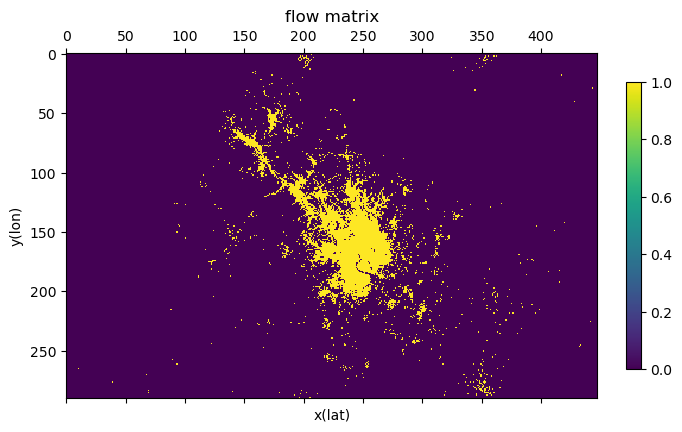

In [35]:
HZ_flow = visualization(HZXD, HZ_max_X+1, HZ_max_Y+1)

In [36]:
HZ_xmin = 140
HZ_xmax = 310
HZ_ymin = 0
HZ_ymax = 240
HZXD = HZXD[:,HZ_xmin:HZ_xmax,HZ_ymin:HZ_ymax,:]

In [41]:
HZ_sub_num = partition(HZXD, 3, "HZ")
HZ_sub_num

330

#### Chengdu Xiangdao

In [15]:
CD_df11 = dataprocess('data_chengdu_202111.csv', 11)
CD_df12 = dataprocess('data_chengdu_202112.csv', 12)

CD_df11gird, CD_df12gird = togird(CD_df11, CD_df12)
CD_max_X = max(max(CD_df11gird['destination_X']),max(CD_df11gird['origin_X']),max(CD_df12gird['destination_X']),max(CD_df12gird['origin_X']))
CD_max_Y = max(max(CD_df11gird['destination_Y']),max(CD_df11gird['origin_Y']),max(CD_df12gird['destination_Y']),max(CD_df12gird['origin_Y']))

CD_tf11_in = gettf(CD_df11gird, 'in', CD_max_X+1)
CD_tf11_out = gettf(CD_df11gird, 'out', CD_max_X+1)
CD_tf12_in = gettf(CD_df12gird, 'in', CD_max_X+1)
CD_tf12_out = gettf(CD_df12gird, 'out', CD_max_X+1)

CDXD = generate_data(CD_tf11_in, CD_tf11_out, CD_tf12_in, CD_tf12_out, CD_max_X+1, CD_max_Y+1)

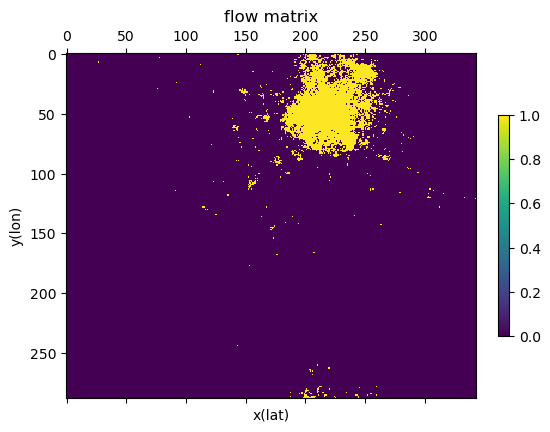

In [25]:
CD_flow = visualization(CDXD, CD_max_X+1, CD_max_Y+1)

In [27]:
CD_xmin = 130
CD_xmax = 300
CD_ymin = 0
CD_ymax = 100
CDXD = CDXD[:,CD_xmin:CD_xmax,CD_ymin:CD_ymax,:]

In [34]:
CD_sub_num = partition(CDXD, 2, "CD")
CD_sub_num

113

#### Shanghai Xiangdao

In [37]:
SH_df11 = dataprocess('data_shanghai_202111.csv', 11)
SH_df12 = dataprocess('data_shanghai_202112.csv', 12)

SH_df11gird, SH_df12gird = togird(SH_df11, SH_df12)
SH_max_X = max(max(SH_df11gird['destination_X']),max(SH_df11gird['origin_X']),max(SH_df12gird['destination_X']),max(SH_df12gird['origin_X']))
SH_max_Y = max(max(SH_df11gird['destination_Y']),max(SH_df11gird['origin_Y']),max(SH_df12gird['destination_Y']),max(SH_df12gird['origin_Y']))

SH_tf11_in = gettf(SH_df11gird, 'in', SH_max_X+1)
SH_tf11_out = gettf(SH_df11gird, 'out', SH_max_X+1)
SH_tf12_in = gettf(SH_df12gird, 'in', SH_max_X+1)
SH_tf12_out = gettf(SH_df12gird, 'out', SH_max_X+1)

SHXD = generate_data(SH_tf11_in, SH_tf11_out, SH_tf12_in, SH_tf12_out, SH_max_X+1, SH_max_Y+1)

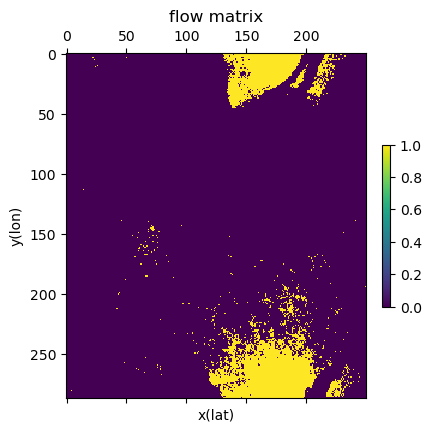

In [38]:
SH_flow = visualization(SHXD, SH_max_X+1, SH_max_Y+1)

In [39]:
SH_xmin = 100
SH_y1 = 180
SH_y2 = 50
SHXD1 = SHXD[:,SH_xmin:,SH_y1:,:]
SHXD2 = SHXD[:,SH_xmin:,:SH_y2,:]
SHXD = np.concatenate((SHXD1, SHXD2), axis=2)

In [40]:
SH_sub_num = partition(SHXD, 3, "SH")
SH_sub_num

132